In [111]:
%matplotlib inline
import gym
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from collections import namedtuple, deque
from IPython import display
# pip install git+https://github.com/jakevdp/JSAnimation.git
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from scipy import stats
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
env = gym.make('CartPole-v1')
print('Actions: {}'.format(env.action_space.n))
print('Raw observation space: {}'.format(env.observation_space.shape))
print('Max episode steps: {}'.format(env.spec.max_episode_steps))

WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.
Actions: 2
Raw observation space: (4,)
Max episode steps: 500


((4,), 1.0)
count    4.000000
mean     0.055903
std      0.200012
min     -0.147495
25%     -0.031855
50%      0.020021
75%      0.107779
max      0.331064
dtype: float64


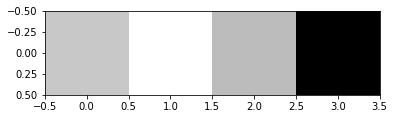

In [9]:
def test(env):
    state = env.reset()
    state, reward, done, info = env.step(env.action_space.sample())
    print(state.shape, reward)
    print(pd.Series(state).describe())
    plt.imshow(state.reshape((1, len(state))), cmap='Greys')

test(env)

In [127]:
class LearningParameters:
    def __init__(self, env, state, episodes_count):
        self.state_shape = state.shape
        self.state_size = np.prod(self.state_shape)
        self.action_size = env.action_space.n
        self.episodes_count = episodes_count
        self.max_frame_in_episode = env.spec.max_episode_steps
        self.max_memory_size = 100000
        self.episodes_between_think = 1

        self.gamma = 0.95                # rewards discount rate
        self.epsilon = 1.0               # exploration rate
        self.epsilon_start = self.epsilon
        self.epsilon_min = 0.0001        # min exploration rate
        self.learning_rate = 0.1         # learning rate for algorithm
        self.learning_rate_model = 0.01  # learning rate for model
        self.batch_size = 32
        
        self.reward_is_time = False
        self.discount_rewards = True
        self.normalize_rewards = True

def decay_exploration_rate(params, episode):
    # Exponential rate decay
    # y(0) = start
    # y(1) = start * x
    # y(2) = start * x^2
    # y(steps) = start * x^steps = min => x = (min/start) ^ (1/steps)
    # y(t) = start * x^t
    x = math.pow(params.epsilon_min / params.epsilon_start, 1.0 / params.episodes_count)
    params.epsilon = params.epsilon_start * math.pow(x, episode)

def set_rewards_time(episode_rewards):
    for i in range(len(episode_rewards)):
        episode_rewards[i] = len(episode_rewards) - i

def set_discount_rewards(episode_rewards):
    discounted_reward = 0.0
    for i in reversed(range(len(episode_rewards))):
        reward = episode_rewards[i]
        if params.pong_reset_discounted_reward and reward != 0:
            discounted_reward = 0.0
        discounted_reward = reward + discounted_reward * params.gamma
        episode_rewards[i] = discounted_reward
        
def get_normalized_rewards(episode_rewards):
    episode_rewards -= np.mean(episode_rewards)
    std = np.std(episode_rewards)
    if std != 0:
        episode_rewards /= std
    return episode_rewards
        
def train(session, env, agent, params):
    rewards = []

    for episode in range(params.episodes_count):
        state = env.reset()

        replays = []

        for frame in range(params.max_frame_in_episode):
            action = agent.act(session, state, frame)

            next_state, reward, done, _ = env.step(action)

            if done:
                break

            replays.append((frame, state, action, reward, next_state))
            state = next_state

        episode_rewards = list(r[3] for r in replays)
        rewards.append(sum(episode_rewards))
        
        if params.reward_is_time:
            set_rewards_time(episode_rewards)
        if params.discount_rewards:
            set_discount_rewards(episode_rewards)
        if params.normalize_rewards:
            episode_rewards = get_normalized_rewards(episode_rewards)

        for i in range(len(replays)):
            frame, state, action, _, next_state = replays[i]
            agent.remember(state, action, episode_rewards[i], next_state, frame)

        if (episode + 1) % max(1, (params.episodes_count / 20)) == 0:
            print("episode: {}/{}, reward {}, frames {}, exploration rate: {:.2}".format(
                episode + 1,
                params.episodes_count,
                np.mean(rewards[-10:]),
                len(replays),
                params.epsilon))

        if (episode + 1) % params.episodes_between_think == 0:
            agent.think(session, params.batch_size, episode)

        decay_exploration_rate(params, episode)

    return agent, rewards

# https://stackoverflow.com/questions/38189119/simple-way-to-visualize-a-tensorflow-graph-in-jupyter
from IPython.display import clear_output, Image, display, HTML
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [346]:
class DqnAgent:
    def __init__(self, params):
        self.params = params
        self.memory_states = np.zeros((2 * self.params.max_memory_size, self.params.state_size))
        self.memory_next_states = np.zeros((2 * self.params.max_memory_size, self.params.state_size))
        self.memory_actions = np.zeros((2 * self.params.max_memory_size), dtype=np.int32)
        self.memory_rewards = np.zeros((2 * self.params.max_memory_size, 1))
        self.cnt = 0
        self._build_model()

    def _build_model(self):
        self.x = tf.placeholder("float", [None, self.params.state_size], name="Placeholder_x")
        self.y = tf.placeholder("float", [None, self.params.action_size], name="Placeholder_y")

        fc1 = tf.contrib.layers.fully_connected(
            self.x,
            12,
            activation_fn=tf.nn.relu,
            weights_initializer=tf.contrib.layers.xavier_initializer())
        
        self.pred = tf.contrib.layers.fully_connected(
            inputs=fc1,
            num_outputs=self.params.action_size,
            activation_fn=None,
            weights_initializer=tf.contrib.layers.xavier_initializer())
        
        self.cost = tf.reduce_mean(tf.squared_difference(self.pred, self.y))

        self.train_op = tf.train.RMSPropOptimizer(learning_rate=self.params.learning_rate, decay=0.99) \
            .minimize(self.cost)

    def remember(self, state, action, reward, next_state, frame):
        self.memory_states[self.cnt] = state
        self.memory_next_states[self.cnt] = next_state
        self.memory_actions[self.cnt] = action
        self.memory_rewards[self.cnt] = reward
        self.cnt += 1
        
        if self.cnt == 2 * self.params.max_memory_size:
            n = self.params.max_memory_size
            self.memory_states[:n] = self.memory_states[-n:]
            self.memory_next_states[:n] = self.memory_next_states[-n:]
            self.memory_actions[:n] = self.memory_actions[-n:]
            self.memory_rewards[:n] = self.memory_rewards[-n:]
            self.cnt = n

    def act(self, session, state, frame):
        if np.random.rand() <= self.params.epsilon:
            return np.random.randint(0, self.params.action_size)
        return self.act_greedy(session, state, frame)
    
    def act_greedy(self, session, state, frame):
        act_values = session.run(self.pred, {self.x: [state]})[0]
        return np.argmax(act_values)

    def think(self, session, batch_size, episode):
        cnt = self.cnt
        
        values = session.run(self.pred, {self.x: self.memory_states[:cnt]})
        nextValues = session.run(self.pred, {self.x: self.memory_next_states[:cnt]})
        
        values[np.arange(cnt), self.memory_actions[:cnt]] = \
            self.memory_rewards[:cnt, 0] + self.params.gamma * np.amax(nextValues, axis=1)

        P = np.random.permutation(cnt)
        for i in range(0, cnt, batch_size):
            batch_indexes = P[i: i + batch_size]
            batch_x = self.memory_states[batch_indexes]
            batch_y = values[batch_indexes]
            _ = session.run(self.train_op, {self.x: batch_x, self.y: batch_y})

In [615]:
class DqnAgentModified:
    def __init__(self, params):
        self.params = params
        self.memory_states = np.zeros((2 * self.params.max_memory_size, self.params.state_size))
        self.memory_next_states = np.zeros((2 * self.params.max_memory_size, self.params.state_size))
        self.memory_actions = np.zeros((2 * self.params.max_memory_size), dtype=np.int32)
        self.memory_rewards = np.zeros((2 * self.params.max_memory_size))
        self.cnt = 0
        self._build_model()

    def _build_model(self):
        self.x = tf.placeholder("float", [None, self.params.state_size], name="Placeholder_x")
        self.a = tf.placeholder("int32", [None], name="Placeholder_a")
        self.y = tf.placeholder("float", [None], name="Placeholder_y")
        
        actions_ohe = tf.one_hot(self.a, depth=self.params.action_size, axis=-1)
        print('actions_ohe:', actions_ohe)

        inp = tf.concat([actions_ohe, self.x], axis=1)
        print('inp', inp)
        
        fc1 = tf.contrib.layers.fully_connected(
            inp,
            12,
            activation_fn=tf.nn.relu,
            weights_initializer=tf.contrib.layers.xavier_initializer())
        print('fc1', fc1)
        
        self.pred = tf.contrib.layers.fully_connected(
            inputs=fc1,
            num_outputs=1,
            activation_fn=None,
            weights_initializer=tf.contrib.layers.xavier_initializer())
        print('self.pred', self.pred)
        
        self.cost = tf.reduce_mean(tf.squared_difference(self.pred, self.y))
        print('self.cost', self.cost)

        self.train_op = tf.train.GradientDescentOptimizer(learning_rate=self.params.learning_rate) \
            .minimize(self.cost)

    def remember(self, state, action, reward, next_state, frame):
        self.memory_states[self.cnt] = state
        self.memory_next_states[self.cnt] = next_state
        self.memory_actions[self.cnt] = action
        self.memory_rewards[self.cnt] = reward
        self.cnt += 1
        
        if self.cnt == 2 * self.params.max_memory_size:
            n = self.params.max_memory_size
            self.memory_states[:n] = self.memory_states[-n:]
            self.memory_next_states[:n] = self.memory_next_states[-n:]
            self.memory_actions[:n] = self.memory_actions[-n:]
            self.memory_rewards[:n] = self.memory_rewards[-n:]
            self.cnt = n

    def act(self, session, state, frame):
        if np.random.rand() <= self.params.epsilon:
            return np.random.randint(0, self.params.action_size)
        return self.act_greedy(session, state, frame)
    
    def act_greedy(self, session, state, frame):
        act_values = session.run(self.pred, {self.x: [state, state], self.a: [0, 1]})
        return np.argmax(act_values)

    def think(self, session, batch_size, episode):
        cnt = self.cnt
        
        a0 = np.zeros(cnt, dtype='int32')
        a1 = np.ones(cnt, dtype='int32')
        
        nextValues = np.zeros((cnt, self.params.action_size))
        nextValues[:,0] = session.run(self.pred, {self.x: self.memory_next_states[:cnt], self.a: a0})[:,0]
        nextValues[:,1] = session.run(self.pred, {self.x: self.memory_next_states[:cnt], self.a: a1})[:,0]
        
        Y = self.memory_rewards[:cnt] + self.params.gamma * np.amax(nextValues, axis=1)
        
        cost_before = session.run(self.cost, {
            self.x: self.memory_states[:cnt],
            self.a: self.memory_actions[:cnt],
            self.y: Y})
        
        cost_after = cost_before
        for epoch in range(10):
            
            P = np.random.permutation(cnt)
            for i in range(0, len(P), batch_size):
                batch_indexes = P[i: i + batch_size]
                batch_x = self.memory_states[batch_indexes, :]
                batch_a = self.memory_actions[batch_indexes]
                batch_y = Y[batch_indexes]
                _ = session.run(self.train_op, {
                    self.x: batch_x,
                    self.a: batch_a,
                    self.y: batch_y})
            
            cost_curr = session.run(self.cost, {
                self.x: self.memory_states[:cnt],
                self.a: self.memory_actions[:cnt],
                self.y: Y})
            
            if cost_curr > cost_after:  # early stopping
                break
            
            cost_after = cost_curr
            
#         print("Dataset {}, epochs {}, cost: {} --> {}".format(cnt, epoch, cost_before, cost_after))

('actions_ohe:', <tf.Tensor 'one_hot:0' shape=(?, 2) dtype=float32>)
('inp', <tf.Tensor 'concat:0' shape=(?, 6) dtype=float32>)
('fc1', <tf.Tensor 'fully_connected/Relu:0' shape=(?, 12) dtype=float32>)
('self.pred', <tf.Tensor 'fully_connected_1/BiasAdd:0' shape=(?, 1) dtype=float32>)
('self.cost', <tf.Tensor 'Mean:0' shape=() dtype=float32>)
episode: 25/500, reward 21.8, frames 30, exploration rate: 0.87
episode: 50/500, reward 21.6, frames 19, exploration rate: 0.75
episode: 75/500, reward 30.5, frames 16, exploration rate: 0.65
episode: 100/500, reward 32.0, frames 16, exploration rate: 0.56
episode: 125/500, reward 39.4, frames 37, exploration rate: 0.48
episode: 150/500, reward 43.2, frames 39, exploration rate: 0.41
episode: 175/500, reward 55.3, frames 82, exploration rate: 0.35
episode: 200/500, reward 30.3, frames 30, exploration rate: 0.31
episode: 225/500, reward 33.4, frames 39, exploration rate: 0.26
episode: 250/500, reward 28.5, frames 10, exploration rate: 0.23
episode:

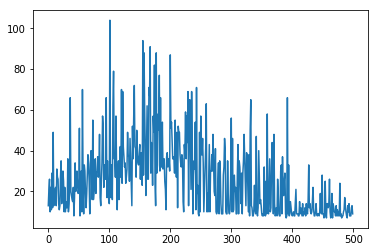

In [617]:
tf.reset_default_graph()

params = LearningParameters(env, env.reset(), episodes_count=500)
params.max_frame_in_episode = min(params.max_frame_in_episode, 500)
params.learning_rate = 0.0003
params.epsilon_min = 0.05
params.max_memory_size = 2000
params.pong_reset_discounted_reward = False
params.reward_is_time = False
params.discount_rewards = True
params.normalize_rewards = True
agent = DqnAgentModified(params)

# Train on GPU
config = tf.ConfigProto(log_device_placement=True)
config.gpu_options.per_process_gpu_memory_fraction=0.7
config.operation_timeout_in_ms=60000

# Train on CPU
# config = tf.ConfigProto(device_count = {'GPU': 0})

with tf.Session(config=config) as session:
    session.run(tf.global_variables_initializer())

    agent, rewards = train(session, env, agent, params)
    
    plt.plot(rewards)

In [640]:
class DqnAgentPredictFuture:
    def __init__(self, params):
        self.params = params
        self.memory_states = np.zeros((2 * self.params.max_memory_size, self.params.state_size))
        self.memory_next_states = np.zeros((2 * self.params.max_memory_size, self.params.state_size))
        self.memory_actions = np.zeros((2 * self.params.max_memory_size), dtype=np.int32)
        self.memory_rewards = np.zeros((2 * self.params.max_memory_size))
        self.cnt = 0
        self._build_model()

    def _build_model(self):
        self.x = tf.placeholder("float", [None, self.params.state_size], name="Placeholder_x")
        self.xnext = tf.placeholder("float", [None, self.params.state_size], name="Placeholder_xnext")
        self.a = tf.placeholder("int32", [None], name="Placeholder_a")
        self.y = tf.placeholder("float", [None], name="Placeholder_y")
        
        actions_ohe = tf.one_hot(self.a, depth=self.params.action_size, axis=-1)
        print('actions_ohe:', actions_ohe)

        inp = tf.concat([actions_ohe, self.x], axis=1)
        print('inp', inp)
        
        inner = tf.contrib.layers.fully_connected(
            inp,
            30,
            activation_fn=tf.nn.relu,
            weights_initializer=tf.contrib.layers.xavier_initializer())
        print('inner', inner)
        
        self.prednext = tf.contrib.layers.fully_connected(
            inputs=inner,
            num_outputs=self.params.state_size,
            activation_fn=None,
            weights_initializer=tf.contrib.layers.xavier_initializer())
        print('self.prednext', self.prednext)
        
        self.pred = tf.contrib.layers.fully_connected(
            inputs=inner,
            num_outputs=1,
            activation_fn=None,
            weights_initializer=tf.contrib.layers.xavier_initializer())
        print('self.pred', self.pred)
        
        self.cost = tf.reduce_mean(tf.squared_difference(self.pred, self.y)) +\
            tf.reduce_mean(tf.squared_difference(self.prednext, self.xnext))
        print('self.cost', self.cost)

        self.train_op = tf.train.GradientDescentOptimizer(learning_rate=self.params.learning_rate) \
            .minimize(self.cost)

    def remember(self, state, action, reward, next_state, frame):
        self.memory_states[self.cnt] = state
        self.memory_next_states[self.cnt] = next_state
        self.memory_actions[self.cnt] = action
        self.memory_rewards[self.cnt] = reward
        self.cnt += 1
        
        if self.cnt == 2 * self.params.max_memory_size:
            n = self.params.max_memory_size
            self.memory_states[:n] = self.memory_states[-n:]
            self.memory_next_states[:n] = self.memory_next_states[-n:]
            self.memory_actions[:n] = self.memory_actions[-n:]
            self.memory_rewards[:n] = self.memory_rewards[-n:]
            self.cnt = n

    def act(self, session, state, frame):
        if np.random.rand() <= self.params.epsilon:
            return np.random.randint(0, self.params.action_size)
        return self.act_greedy(session, state, frame)
    
    def act_greedy(self, session, state, frame):
        act_values = session.run(self.pred, {self.x: [state, state], self.a: [0, 1]})
        return np.argmax(act_values)

    def think(self, session, batch_size, episode):
        cnt = self.cnt
        
        a0 = np.zeros(cnt, dtype='int32')
        a1 = np.ones(cnt, dtype='int32')
        
        predX0, Q0 = session.run(
            [self.prednext, self.pred],
            {self.x: self.memory_next_states[:cnt], self.a: a0})
        
        predX1, Q1 = session.run(
            [self.prednext, self.pred],
            {self.x: self.memory_next_states[:cnt], self.a: a1})
        
        predXb = []
        Qb = []
        for i in range(cnt):
            if Q0[i,0] >= Q1[i,0]:
                predXb.append(predX0[i,:])
                Qb.append(Q0[i,0])
            else:
                predXb.append(predX1[i,:])
                Qb.append(Q1[i,0])
        
        predXb = np.array(predXb)
        Qb = np.array(Qb)
        
        predXb0, Qb0 = session.run(
            [self.prednext, self.pred],
            {self.x: predXb, self.a: a0})
        
        predXb1, Qb1 = session.run(
            [self.prednext, self.pred],
            {self.x: predXb, self.a: a1})
        
        nextValues = np.zeros((cnt, self.params.action_size))
        nextValues[:,0] = Qb0[:,0]
        nextValues[:,1] = Qb1[:,0]

        Y = self.memory_rewards[:cnt] + \
            self.params.gamma * Qb + \
            self.params.gamma * self.params.gamma * np.amax(nextValues, axis=1)

#         nextValues = np.zeros((cnt, self.params.action_size))
#         nextValues[:,0] = session.run(self.pred, {self.x: self.memory_next_states[:cnt], self.a: a0})[:,0]
#         nextValues[:,1] = session.run(self.pred, {self.x: self.memory_next_states[:cnt], self.a: a1})[:,0]

#         Y = self.memory_rewards[:cnt] + self.params.gamma * np.amax(nextValues, axis=1)

        

        cost_before = session.run(self.cost, {
            self.x: self.memory_states[:cnt],
            self.xnext: self.memory_next_states[:cnt],
            self.a: self.memory_actions[:cnt],
            self.y: Y})

        cost_after = cost_before
        for epoch in range(10):

            P = np.random.permutation(cnt)
            for i in range(0, len(P), batch_size):
                batch_indexes = P[i: i + batch_size]
                batch_x = self.memory_states[batch_indexes, :]
                batch_xnext = self.memory_next_states[batch_indexes, :]
                batch_a = self.memory_actions[batch_indexes]
                batch_y = Y[batch_indexes]
                _ = session.run(self.train_op, {
                    self.x: batch_x,
                    self.xnext: batch_xnext[:cnt],
                    self.a: batch_a,
                    self.y: batch_y})

            cost_curr = session.run(self.cost, {
                self.x: self.memory_states[:cnt],
                self.xnext: self.memory_next_states[:cnt],
                self.a: self.memory_actions[:cnt],
                self.y: Y})

            if cost_curr > cost_after:  # early stopping
                break

            cost_after = cost_curr

#         print("Dataset {}, epochs {}, cost: {} --> {}".format(cnt, epoch, cost_before, cost_after))

In [469]:
tf.reset_default_graph()
params = LearningParameters(env, env.reset(), episodes_count=1000)
DqnAgentModified(params)
# show_graph(tf.get_default_graph().as_graph_def())

('actions_ohe:', <tf.Tensor 'one_hot:0' shape=(?, 2) dtype=float32>)
('inp', <tf.Tensor 'concat:0' shape=(?, 6) dtype=float32>)
('fc1', <tf.Tensor 'fully_connected/Relu:0' shape=(?, 12) dtype=float32>)
('self.pred', <tf.Tensor 'fully_connected_1/BiasAdd:0' shape=(?, 1) dtype=float32>)
('self.cost', <tf.Tensor 'Mean:0' shape=() dtype=float32>)


<__main__.DqnAgentModified instance at 0x123acbcb0>

('actions_ohe:', <tf.Tensor 'one_hot:0' shape=(?, 2) dtype=float32>)
('inp', <tf.Tensor 'concat:0' shape=(?, 6) dtype=float32>)
('inner', <tf.Tensor 'fully_connected/Relu:0' shape=(?, 30) dtype=float32>)
('self.prednext', <tf.Tensor 'fully_connected_1/BiasAdd:0' shape=(?, 4) dtype=float32>)
('self.pred', <tf.Tensor 'fully_connected_2/BiasAdd:0' shape=(?, 1) dtype=float32>)
('self.cost', <tf.Tensor 'add:0' shape=() dtype=float32>)
episode: 25/500, reward 17.5, frames 9, exploration rate: 0.87
episode: 50/500, reward 21.2, frames 17, exploration rate: 0.75
episode: 75/500, reward 15.6, frames 26, exploration rate: 0.65
episode: 100/500, reward 13.3, frames 8, exploration rate: 0.56
episode: 125/500, reward 14.1, frames 15, exploration rate: 0.48
episode: 150/500, reward 10.2, frames 8, exploration rate: 0.41
episode: 175/500, reward 9.9, frames 11, exploration rate: 0.35
episode: 200/500, reward 9.4, frames 10, exploration rate: 0.31
episode: 225/500, reward 9.3, frames 8, exploration ra

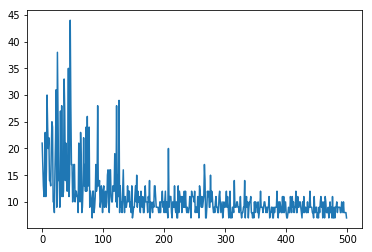

In [641]:
tf.reset_default_graph()

params = LearningParameters(env, env.reset(), episodes_count=500)
params.max_frame_in_episode = min(params.max_frame_in_episode, 500)
params.learning_rate = 0.001
params.epsilon_min = 0.05
params.max_memory_size = 2000
params.pong_reset_discounted_reward = False
params.reward_is_time = False
params.discount_rewards = True
params.normalize_rewards = True
agent = DqnAgentPredictFuture(params)

# Train on GPU
config = tf.ConfigProto(log_device_placement=True)
config.gpu_options.per_process_gpu_memory_fraction=0.7
config.operation_timeout_in_ms=60000

# Train on CPU
# config = tf.ConfigProto(device_count = {'GPU': 0})

with tf.Session(config=config) as session:
    session.run(tf.global_variables_initializer())

    agent, rewards = train(session, env, agent, params)
    
    plt.plot(rewards)

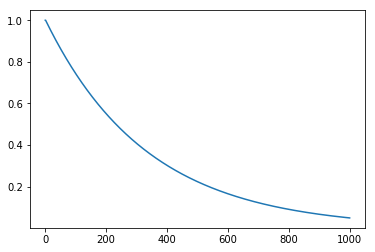

In [76]:
def plot_decay():
    rates = [params.epsilon_start]
    for i in range(params.episodes_count):
        decay_exploration_rate(params, i)
        rates.append(params.epsilon)
    return rates
plt.plot(plot_decay());